[View in Colaboratory](https://colab.research.google.com/github/rafaelszp/dlnd_face_generation/blob/master/dlnd_face_generation.ipynb)

# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
#!git clone https://github.com/rafaelszp/dlnd_face_generation.git
#!cp dlnd_face_generation/*.py .
!pip install -U matplotlib==2.0.2
#!pip install tqdm

    100% |████████████████████████████████| 14.6MB 48kB/s  eta 0:00:01
Requirement already up-to-date: six>=1.10 in /opt/conda/lib/python3.6/site-packages (from matplotlib==2.0.2)
    100% |████████████████████████████████| 12.2MB 57kB/s  eta 0:00:01
    100% |████████████████████████████████| 215kB 3.3MB/s eta 0:00:01
Requirement already up-to-date: cycler>=0.10 in /opt/conda/lib/python3.6/site-packages/cycler-0.10.0-py3.6.egg (from matplotlib==2.0.2)
Requirement already up-to-date: pyparsing!=2.0.0,!=2.0.4,!=2.1.2,!=2.1.6,>=1.5.6 in /opt/conda/lib/python3.6/site-packages (from matplotlib==2.0.2)
    100% |████████████████████████████████| 512kB 1.5MB/s eta 0:00:01
  Found existing installation: numpy 1.12.1
    Uninstalling numpy-1.12.1:
      Successfully uninstalled numpy-1.12.1
  Found existing installation: python-dateutil 2.6.1
    Uninstalling python-dateutil-2.6.1:
      Successfully uninstalled python-dateutil-2.6.1
  Found existing installation: pytz 2017.3
    Uninstalling 

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

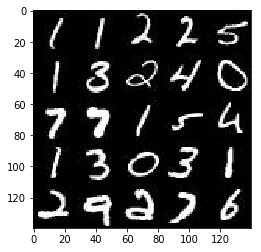

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

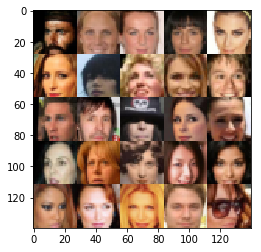

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    x = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels),name='input_real')
    z = tf.placeholder(tf.float32, shape=(None, z_dim),name='noise')
    l = tf.placeholder(tf.float32,name='learning_rate')

    return x, z, l



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

In [6]:

leakyRelu = lambda x,alpha=0.2: tf.maximum(x*alpha,x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [67]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    kernel_init = tf.random_normal_initializer(stddev=0.02)
    
    def conv(images, n_filters, kernel_size=4, strides=2, kernel_initializer=kernel_init, padding='same',is_first=False):
      x = tf.layers.conv2d(images, n_filters, kernel_size, strides, kernel_initializer=kernel_initializer, padding=padding)
      if(is_first):
        x = tf.layers.batch_normalization(x, training=True)
      x = leakyRelu(x)

      return x
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28x28x3
        x = conv(images,64,is_first=True)
        # 14x14x64        
        x = conv(x,128)
        # 7x7x128
        x = conv(x,256)
        # 4x4x256
        x = tf.nn.dropout(x,keep_prob=0.9)
        
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [68]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    kernel_init = tf.random_normal_initializer(stddev=0.02)
    
    def deconv(inputs, n_filters, kernel_size=4, strides=2, kernel_initializer=kernel_init, padding='same',is_last=False):
      x = tf.layers.conv2d_transpose(inputs, n_filters, kernel_size, strides=strides, kernel_initializer=kernel_initializer, padding=padding)
      if(not is_last):
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leakyRelu(x)
        

      return x
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leakyRelu(x)        
        
        # 7x7x256
        x = deconv(x,128)
        # 14x14x128
        x = deconv(x,64)
        # 28x28x64
        x = tf.nn.dropout(x,keep_prob=0.9)
        
        
        logits = deconv(x,n_filters=out_channel_dim,kernel_size=3,strides=1,is_last=True)
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [84]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
            
    gmodel = generator(input_z,out_channel_dim,is_train=True)
    dmodel, dmodel_logits = discriminator(input_real,reuse=False) 
    gxdmodel, gxdmodel_logits = discriminator(gmodel,reuse=True)
    
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dmodel_logits,labels=tf.ones_like(dmodel)))
    gxdloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gxdmodel_logits,labels=tf.zeros_like(gxdmodel)))
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gxdmodel_logits,labels=tf.ones_like(gxdmodel)))
    
    dloss = dloss + gxdloss
    
    
    return dloss, gloss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [85]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [g for g in t_vars if g.name.startswith('generator')]
    d_vars = [d for d in t_vars if d.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
      d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(d_loss,var_list=d_vars)
      g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(g_loss,var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [86]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [87]:
import time

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    images, noisez, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    dloss,gloss = model_loss(images,noisez,data_shape[3])
    d_train_opt,g_train_opt = model_opt(dloss,gloss,learning_rate,beta1)
    iterations = 0
    
    start_time = time.time()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                """
                As suggested here: 
                    https://discussions.udacity.com/t/struggling-with-hyperparameters/635205/2 
                and here:
                    https://discussions.udacity.com/t/generator-loss-is-increasing/303007/2
                I multiplied batch_images by 2.
                Before that, I was generating noise from (-0.5,0.5) but my model was yet broken. After following the suggested
                instruction, the resolution is better.
                """
                batch_images *=2.0
                iterations +=1
                batch_noisez = np.random.uniform(-1,1,size=(batch_size,z_dim))
                dict_d = {
                  images: batch_images,
                  noisez: batch_noisez
                }
                dict_g = {
                    noisez: batch_noisez,
                    images: batch_images,
                }
                _ = sess.run(d_train_opt,feed_dict=dict_d)
                _ = sess.run(g_train_opt,feed_dict=dict_g)
                #calculating loss for the blablablablablalbla
                if(iterations % 10==0):
                  train_loss_d = dloss.eval({images:batch_images,noisez:batch_noisez})
                  train_loss_g = gloss.eval({noisez: batch_noisez})
                  print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                  
                if iterations % 100 == 0:
                    print("iteration",iterations)
                    show_generator_output(sess, 25, noisez, data_shape[3], data_image_mode)
        secs_duration = (time.time() - start_time)
        mins_duration = secs_duration/60
        
        print('Training done seconds: {}. Time in minutes: {}'.format(secs_duration,mins_duration))
                
      

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Starting...
Epoch 1/2... Discriminator Loss: 0.8357... Generator Loss: 0.8613
Epoch 1/2... Discriminator Loss: 1.0776... Generator Loss: 0.7674
Epoch 1/2... Discriminator Loss: 1.0602... Generator Loss: 0.5098
Epoch 1/2... Discriminator Loss: 1.2404... Generator Loss: 2.3538
Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 0.8675
Epoch 1/2... Discriminator Loss: 1.3072... Generator Loss: 1.5401
Epoch 1/2... Discriminator Loss: 1.2055... Generator Loss: 0.5299
Epoch 1/2... Discriminator Loss: 1.0918... Generator Loss: 1.0636
Epoch 1/2... Discriminator Loss: 1.1772... Generator Loss: 0.9582
Epoch 1/2... Discriminator Loss: 1.2637... Generator Loss: 1.2335
iteration 100


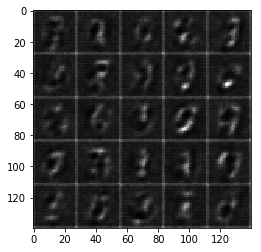

Epoch 1/2... Discriminator Loss: 1.1915... Generator Loss: 0.9836
Epoch 1/2... Discriminator Loss: 1.2330... Generator Loss: 0.5502
Epoch 1/2... Discriminator Loss: 1.1699... Generator Loss: 0.6619
Epoch 1/2... Discriminator Loss: 1.1977... Generator Loss: 0.7419
Epoch 1/2... Discriminator Loss: 1.5748... Generator Loss: 1.4141
Epoch 1/2... Discriminator Loss: 1.6601... Generator Loss: 0.5910
Epoch 1/2... Discriminator Loss: 1.1333... Generator Loss: 0.9668
Epoch 1/2... Discriminator Loss: 0.9794... Generator Loss: 0.9816
Epoch 1/2... Discriminator Loss: 1.5124... Generator Loss: 0.7507
Epoch 1/2... Discriminator Loss: 1.2202... Generator Loss: 0.7390
iteration 200


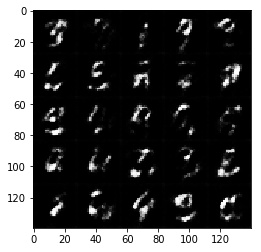

Epoch 1/2... Discriminator Loss: 1.2529... Generator Loss: 0.8067
Epoch 1/2... Discriminator Loss: 1.3581... Generator Loss: 0.7064
Epoch 1/2... Discriminator Loss: 1.0082... Generator Loss: 0.9774
Epoch 1/2... Discriminator Loss: 1.2348... Generator Loss: 0.5765
Epoch 1/2... Discriminator Loss: 1.2685... Generator Loss: 1.1442
Epoch 1/2... Discriminator Loss: 0.9779... Generator Loss: 0.9966
Epoch 1/2... Discriminator Loss: 1.0698... Generator Loss: 1.0753
Epoch 1/2... Discriminator Loss: 1.1787... Generator Loss: 0.8633
Epoch 1/2... Discriminator Loss: 0.9519... Generator Loss: 1.1651
Epoch 1/2... Discriminator Loss: 0.9249... Generator Loss: 0.9628
iteration 300


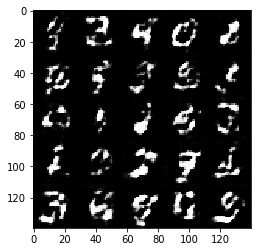

Epoch 1/2... Discriminator Loss: 0.9388... Generator Loss: 0.8653
Epoch 1/2... Discriminator Loss: 1.0548... Generator Loss: 0.7263
Epoch 1/2... Discriminator Loss: 0.9251... Generator Loss: 0.9127
Epoch 1/2... Discriminator Loss: 1.2870... Generator Loss: 0.4485
Epoch 1/2... Discriminator Loss: 0.8437... Generator Loss: 1.0365
Epoch 1/2... Discriminator Loss: 1.1369... Generator Loss: 0.6029
Epoch 1/2... Discriminator Loss: 0.9057... Generator Loss: 1.1134
Epoch 1/2... Discriminator Loss: 0.8584... Generator Loss: 1.7924
Epoch 1/2... Discriminator Loss: 0.9050... Generator Loss: 1.1585
Epoch 1/2... Discriminator Loss: 1.0138... Generator Loss: 0.9644
iteration 400


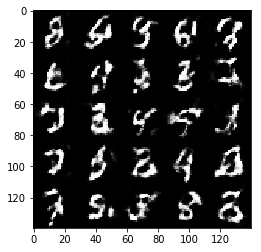

Epoch 1/2... Discriminator Loss: 1.0953... Generator Loss: 0.6300
Epoch 1/2... Discriminator Loss: 0.9608... Generator Loss: 0.9839
Epoch 1/2... Discriminator Loss: 1.3152... Generator Loss: 0.4775
Epoch 1/2... Discriminator Loss: 1.1668... Generator Loss: 1.5919
Epoch 1/2... Discriminator Loss: 1.0138... Generator Loss: 0.9758
Epoch 1/2... Discriminator Loss: 1.1613... Generator Loss: 0.6232
Epoch 2/2... Discriminator Loss: 1.1505... Generator Loss: 0.6233
Epoch 2/2... Discriminator Loss: 1.0705... Generator Loss: 0.8435
Epoch 2/2... Discriminator Loss: 1.0223... Generator Loss: 0.8206
Epoch 2/2... Discriminator Loss: 1.1249... Generator Loss: 0.9282
iteration 500


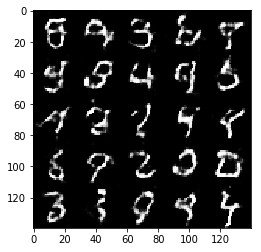

Epoch 2/2... Discriminator Loss: 1.3642... Generator Loss: 1.6996
Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 0.7089
Epoch 2/2... Discriminator Loss: 1.1987... Generator Loss: 0.6526
Epoch 2/2... Discriminator Loss: 1.1553... Generator Loss: 1.1490
Epoch 2/2... Discriminator Loss: 1.1504... Generator Loss: 0.8674
Epoch 2/2... Discriminator Loss: 1.2018... Generator Loss: 0.6092
Epoch 2/2... Discriminator Loss: 1.1341... Generator Loss: 0.9140
Epoch 2/2... Discriminator Loss: 1.2650... Generator Loss: 1.0048
Epoch 2/2... Discriminator Loss: 1.1869... Generator Loss: 0.8538
Epoch 2/2... Discriminator Loss: 1.4766... Generator Loss: 0.3657
iteration 600


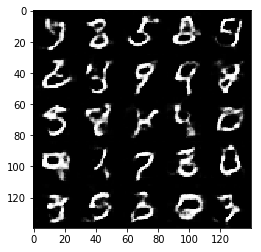

Epoch 2/2... Discriminator Loss: 1.1133... Generator Loss: 0.8366
Epoch 2/2... Discriminator Loss: 1.1401... Generator Loss: 0.9383
Epoch 2/2... Discriminator Loss: 1.2143... Generator Loss: 0.7909
Epoch 2/2... Discriminator Loss: 1.1899... Generator Loss: 1.1678
Epoch 2/2... Discriminator Loss: 1.1584... Generator Loss: 1.0184
Epoch 2/2... Discriminator Loss: 1.2256... Generator Loss: 1.4502
Epoch 2/2... Discriminator Loss: 1.1276... Generator Loss: 0.8711
Epoch 2/2... Discriminator Loss: 1.3132... Generator Loss: 0.9228
Epoch 2/2... Discriminator Loss: 1.2176... Generator Loss: 0.9607
Epoch 2/2... Discriminator Loss: 1.3442... Generator Loss: 0.4869
iteration 700


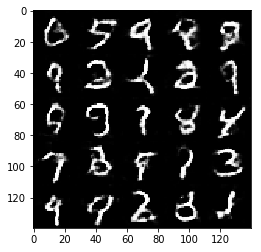

Epoch 2/2... Discriminator Loss: 1.1865... Generator Loss: 1.1131
Epoch 2/2... Discriminator Loss: 1.2586... Generator Loss: 1.1462
Epoch 2/2... Discriminator Loss: 1.2512... Generator Loss: 0.6348
Epoch 2/2... Discriminator Loss: 1.1599... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 1.2186... Generator Loss: 1.1400
Epoch 2/2... Discriminator Loss: 1.2395... Generator Loss: 1.3255
Epoch 2/2... Discriminator Loss: 1.0891... Generator Loss: 0.9113
Epoch 2/2... Discriminator Loss: 1.0831... Generator Loss: 0.9302
Epoch 2/2... Discriminator Loss: 1.2200... Generator Loss: 1.1611
Epoch 2/2... Discriminator Loss: 1.2034... Generator Loss: 0.8890
iteration 800


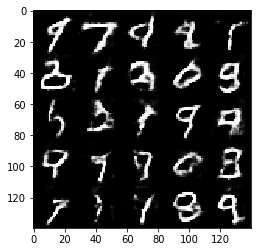

Epoch 2/2... Discriminator Loss: 1.0935... Generator Loss: 1.1667
Epoch 2/2... Discriminator Loss: 1.0126... Generator Loss: 1.0542
Epoch 2/2... Discriminator Loss: 1.0594... Generator Loss: 0.9637
Epoch 2/2... Discriminator Loss: 1.0852... Generator Loss: 0.9315
Epoch 2/2... Discriminator Loss: 1.3305... Generator Loss: 0.5026
Epoch 2/2... Discriminator Loss: 1.1639... Generator Loss: 0.7718
Epoch 2/2... Discriminator Loss: 1.5177... Generator Loss: 1.6024
Epoch 2/2... Discriminator Loss: 1.1380... Generator Loss: 0.9495
Epoch 2/2... Discriminator Loss: 1.2275... Generator Loss: 1.3012
Epoch 2/2... Discriminator Loss: 1.2535... Generator Loss: 0.5797
iteration 900


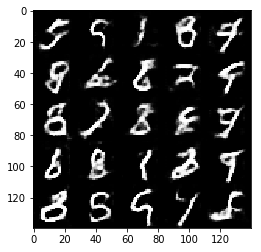

Epoch 2/2... Discriminator Loss: 1.1177... Generator Loss: 1.0062
Epoch 2/2... Discriminator Loss: 1.1707... Generator Loss: 0.7102
Epoch 2/2... Discriminator Loss: 1.1056... Generator Loss: 0.8470
Training done seconds: 181.001131772995. Time in minutes: 3.0166855295499166


In [89]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
print('Starting...')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6403... Generator Loss: 1.1317
Epoch 1/1... Discriminator Loss: 0.7302... Generator Loss: 1.1944
Epoch 1/1... Discriminator Loss: 0.6772... Generator Loss: 1.0940
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 1.7540
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 1.0793
Epoch 1/1... Discriminator Loss: 0.8488... Generator Loss: 1.4734
Epoch 1/1... Discriminator Loss: 1.0027... Generator Loss: 1.9218
Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 0.8457
iteration 100


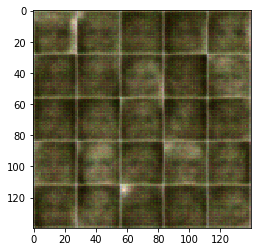

Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 1.1446
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 2.0600
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.5235
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 1.0006
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.7818
iteration 200


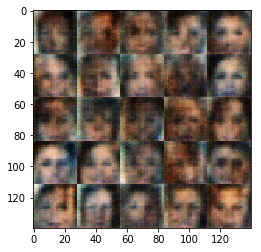

Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.8561
iteration 300


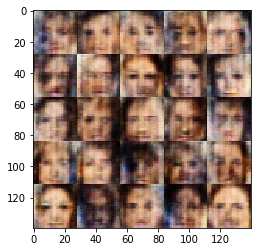

Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.7623
iteration 400


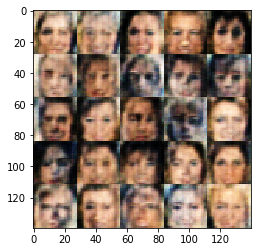

Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7214
iteration 500


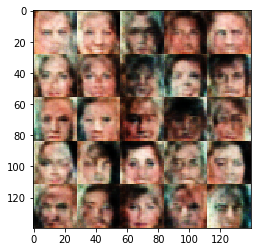

Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.7468
iteration 600


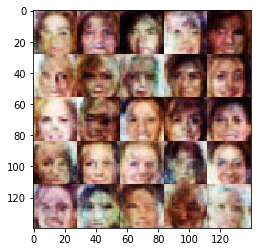

Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.7350
iteration 700


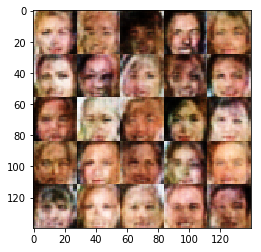

Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.7322
iteration 800


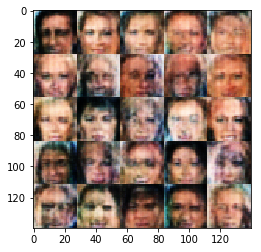

Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7399
iteration 900


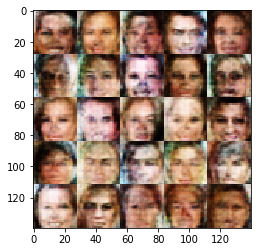

Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.7533
iteration 1000


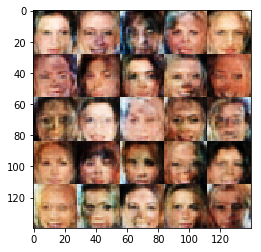

Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.6978
iteration 1100


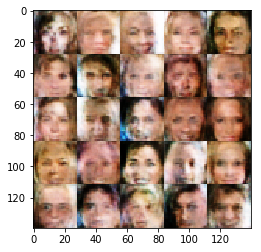

Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.7946
iteration 1200


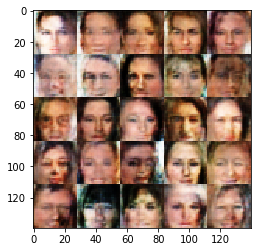

Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.7748
iteration 1300


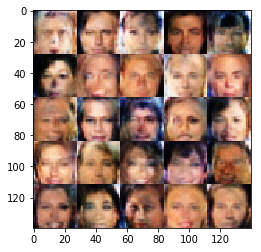

Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7768
iteration 1400


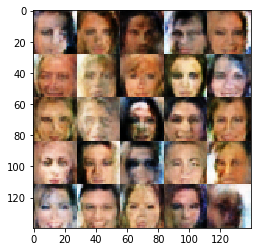

Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.7711
iteration 1500


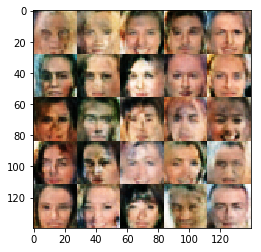

Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.7380
Training done seconds: 467.28142523765564. Time in minutes: 7.788023753960927


In [90]:
batch_size = 128
z_dim = 100
learning_rate = 2e-4
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.